A small test--Can DNN AE properly reconstruct the noise data pattern and pick out the signaled ones?

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import readligo as rl
from gwpy.timeseries import TimeSeries
import math
import random

/opt/homebrew/lib/python3.11/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [2]:
epochs = 400
test_sample_ratio = .2
validation_sample_ratio = 0.1
input_vector_length = 4
batch_size = 32
num_bins = 40
coef_delta = 0.1

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(4, 3),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 4),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [4]:
def normalize(v):
    norm = np.linalg.norm(v)
    junk = 0
    if norm == 0: 
       return v
    return v / norm, junk, norm

In [5]:
def bunch_normalization(v_set):
    recover_min = list(range(len(v_set)))
    recover_coef = list(range(len(v_set)))
    v_set_normalized = np.zeros((v_set.shape[0], v_set.shape[1]))
    for i in range(len(v_set)):
        v_set_normalized[i], recover_min[i], recover_coef[i] = normalize(v_set[i])
    return v_set_normalized, recover_min, recover_coef

In [6]:
data_for_training_and_testing = np.random.normal(scale=.1, size=3*10000).reshape(-1,3)

In [7]:
def generate_random_signal_vector(min_theta, max_theta, min_phi, max_phi):
    theta = random.uniform(min_theta, max_theta)
    phi = random.uniform(min_phi, max_phi)
    
    x = math.sin(theta) * math.cos(phi)
    y = math.sin(theta) * math.sin(phi)
    z = math.cos(theta)
    
    return [x, y, z]

In [9]:
# 指定立体角度区间
min_theta = 0  # 最小极角
max_theta = math.pi  # 最大极角
min_phi = 0  # 最小方位角
max_phi = 2 * math.pi  # 最大方位角

# 生成随机的三维向量
num_vectors = 10000  # 生成向量的数量
vectors = []
for _ in range(num_vectors):
    vector = generate_random_signal_vector(min_theta, max_theta, min_phi, max_phi)
    vectors.append(vector)

# data_for_training_and_testing = np.array(vectors)    
data_for_training_and_testing = np.array(vectors) / np.sqrt(2)

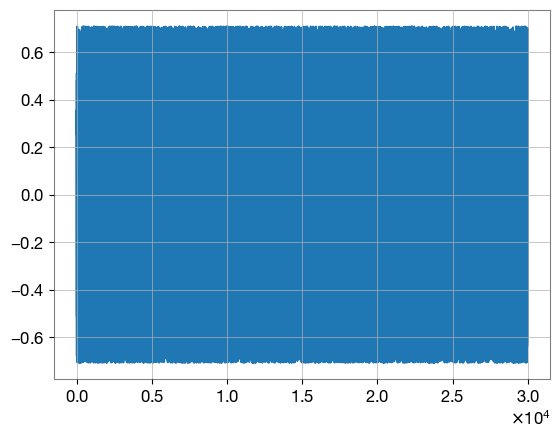

In [10]:
plt.plot(data_for_training_and_testing.flatten())

In [11]:
total_sample_number = data_for_training_and_testing.shape[0]
test_sample_number = int(test_sample_ratio * total_sample_number)
validation_sample_number = int(validation_sample_ratio * total_sample_number)
train_sample_number = total_sample_number - test_sample_number - validation_sample_number


X_train_ini = data_for_training_and_testing[0:train_sample_number-1].copy()
X_test_ini = data_for_training_and_testing[-test_sample_number:].copy()
X_validation_ini = data_for_training_and_testing[train_sample_number:-test_sample_number-1].copy()

X_train, X_train_recover_min, X_train_recover_coef = bunch_normalization(X_train_ini)
X_test, X_test_recover_min, X_test_recover_coef = bunch_normalization(X_test_ini)
X_validation, X_validation_recover_min, X_validation_recover_coef = bunch_normalization(X_validation_ini)

In [12]:
X_train = np.hstack((X_train, np.array(X_train_recover_coef).reshape(6999,1)))
X_validation = np.hstack((X_validation, np.array(X_validation_recover_coef).reshape(999,1)))
X_text = np.hstack((X_test, np.array(X_test_recover_coef).reshape(2000,1)))

In [13]:
trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

In [14]:
testData = torch.FloatTensor(X_text)

In [18]:
train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)


autoencoder = AutoEncoder()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0005)
loss_func = nn.MSELoss()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))


for epoch in range(epochs):
    # 训练阶段
    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        encoded, decoded = autoencoder(x)
        lossTrain = loss_func(decoded, x)
        optimizer.zero_grad()
        lossTrain.backward()
        optimizer.step()

    # 验证阶段
    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            encoded, decoded = autoencoder(x)
            lossVal = loss_func(decoded, x)
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)
    
    loss_train[epoch,0] = lossTrain.item()
    loss_validation[epoch,0] = val_loss
    print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, lossTrain.item(), val_loss))

Epoch: 0001, Training loss=0.37888867, Validation loss=0.36639497
Epoch: 0002, Training loss=0.24049519, Validation loss=0.23369866
Epoch: 0003, Training loss=0.17876872, Validation loss=0.15600278
Epoch: 0004, Training loss=0.12480453, Validation loss=0.12171263
Epoch: 0005, Training loss=0.08313139, Validation loss=0.10417967
Epoch: 0006, Training loss=0.07247657, Validation loss=0.09410709
Epoch: 0007, Training loss=0.09504161, Validation loss=0.08707524
Epoch: 0008, Training loss=0.07872657, Validation loss=0.07905565
Epoch: 0009, Training loss=0.04684101, Validation loss=0.07102868
Epoch: 0010, Training loss=0.07416075, Validation loss=0.05744525
Epoch: 0011, Training loss=0.03113332, Validation loss=0.03965729
Epoch: 0012, Training loss=0.02922973, Validation loss=0.02470635
Epoch: 0013, Training loss=0.01654228, Validation loss=0.01706368
Epoch: 0014, Training loss=0.01037400, Validation loss=0.01331574
Epoch: 0015, Training loss=0.01147098, Validation loss=0.01138620
Epoch: 001

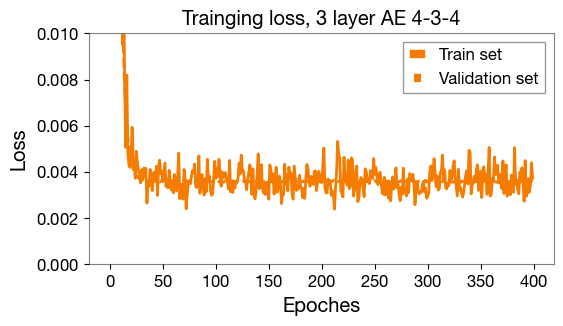

In [210]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 3 layer AE 4-3-4')
plt.legend()
plt.ylim(0,0.01)
plt.show()

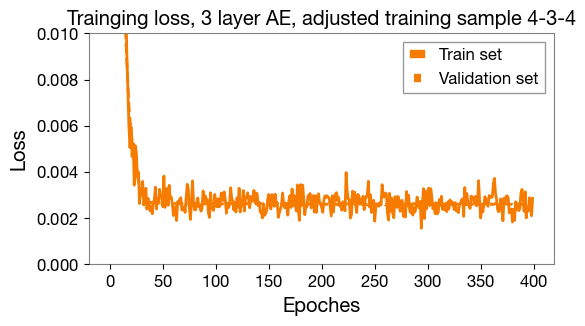

In [19]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 3 layer AE, adjusted training sample 4-3-4')
plt.legend()
plt.ylim(0,0.01)
plt.show()

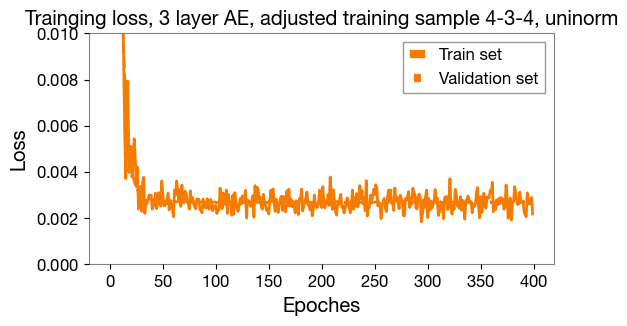

In [16]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 3 layer AE, adjusted training sample 4-3-4, uninorm')
plt.legend()
plt.ylim(0,0.01)
plt.show()

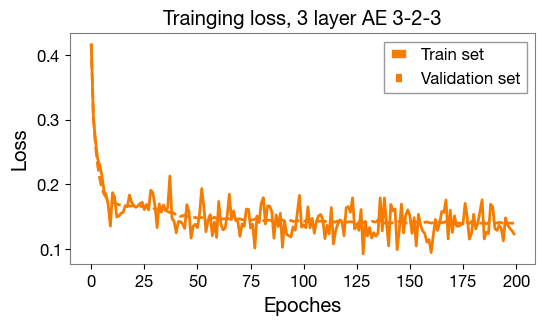

In [170]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 3 layer AE 3-2-3')
plt.legend()
plt.show()

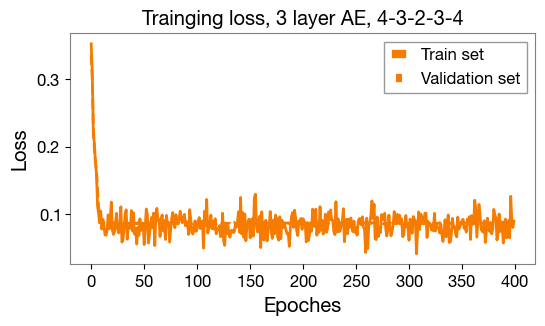

In [188]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 3 layer AE, 4-3-2-3-4')
plt.legend()
plt.show()

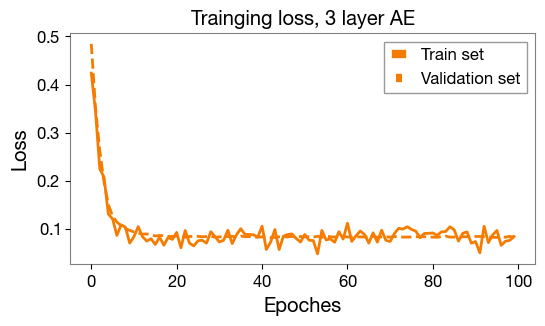

In [138]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 3 layer AE')
plt.legend()
plt.show()

In [265]:
X_train = np.hstack((X_train, np.ones((6999,1))))
trainData = torch.FloatTensor(X_train)

In [20]:
_, decodedTestdata = autoencoder(trainData)
decodedTestdata = decodedTestdata.double()
reconstructedData = decodedTestdata.detach().numpy()
ReconstructedError_train = torch.mean((trainData - reconstructedData)**2,dim=1)
MSE_train = ReconstructedError_train.mean()

ValueError: x and y must have same first dimension, but have shapes (20997,) and (27996,)

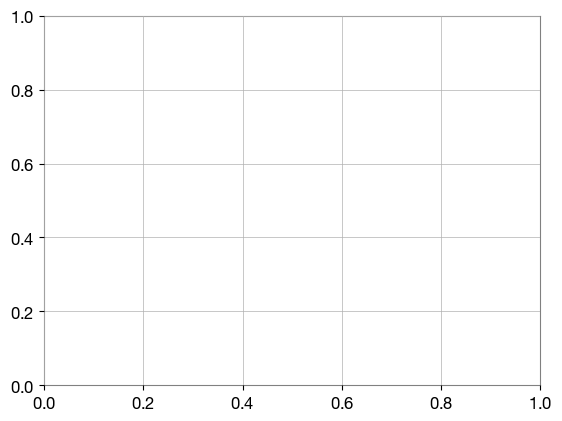

In [285]:
x = np.arange(0, train_sample_number-1, 1/3)
# x = np.arange(0,6,1/3)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData


plt.plot(x, X_train.flatten(), color = 'red', label = 'Input')
plt.plot(x, y.flatten(), label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial Train sample')
plt.xlabel('Seconds')
plt.ylabel('Strain')

In [21]:
X_train = X_train[:, :3]
reconstructedData = reconstructedData[:, :3]

Text(0, 0.5, 'Strain')

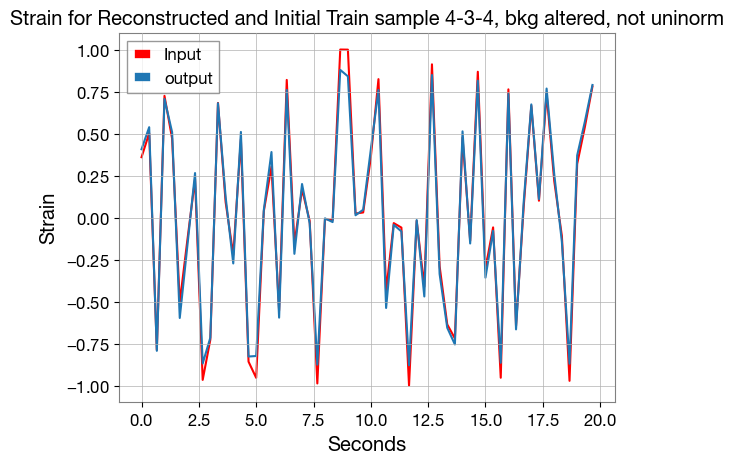

In [22]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,20,1/3)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData


plt.plot(x, X_train.flatten()[0:60], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:60], label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial Train sample 4-3-4, bkg altered, not uninorm')
plt.xlabel('Seconds')
plt.ylabel('Strain')

Text(0, 0.5, 'Strain')

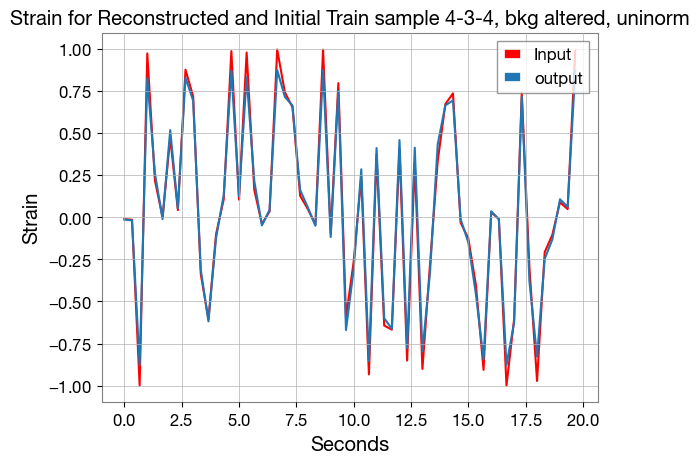

In [19]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,20,1/3)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData


plt.plot(x, X_train.flatten()[0:60], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:60], label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial Train sample 4-3-4, bkg altered, uninorm')
plt.xlabel('Seconds')
plt.ylabel('Strain')

Text(0, 0.5, 'Strain')

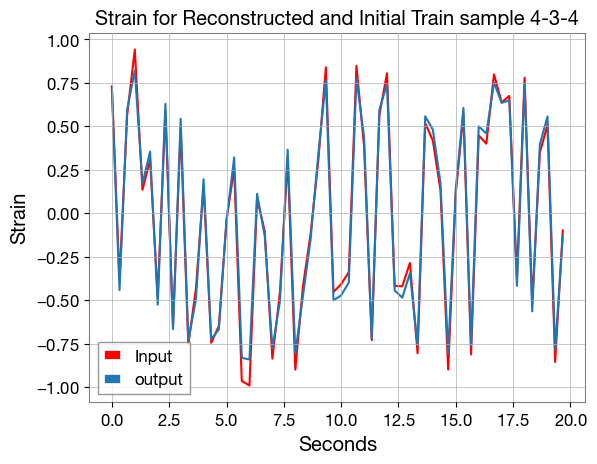

In [213]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,20,1/3)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData


plt.plot(x, X_train.flatten()[0:60], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:60], label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial Train sample 4-3-4')
plt.xlabel('Seconds')
plt.ylabel('Strain')

Text(0, 0.5, 'Strain')

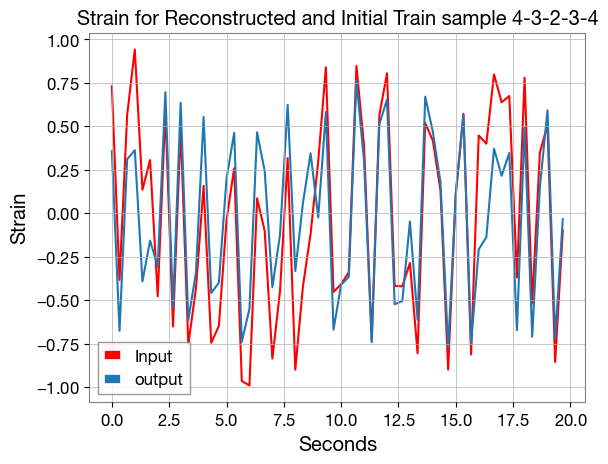

In [191]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,20,1/3)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData


plt.plot(x, X_train.flatten()[0:60], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:60], label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial Train sample 4-3-2-3-4')
plt.xlabel('Seconds')
plt.ylabel('Strain')

Text(0, 0.5, 'Strain')

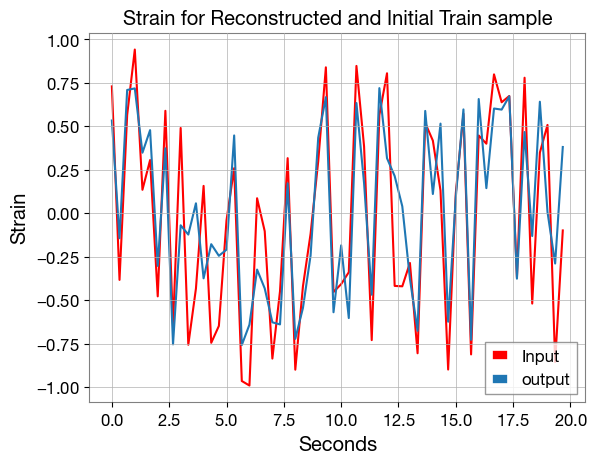

In [144]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,20,1/3)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData


plt.plot(x, X_train.flatten()[0:60], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:60], label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial Train sample')
plt.xlabel('Seconds')
plt.ylabel('Strain')

Text(0, 0.5, 'Strain')

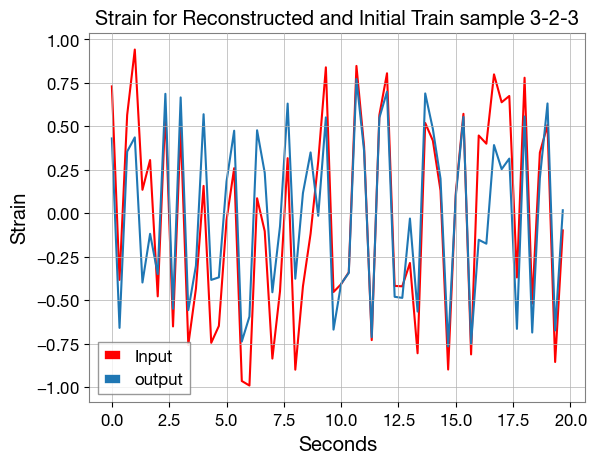

In [151]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,20,1/3)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData


plt.plot(x, X_train.flatten()[0:60], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:60], label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial Train sample 3-2-3')
plt.xlabel('Seconds')
plt.ylabel('Strain')

In [61]:
(y.flatten()[0:3] ** 2).mean()

0.2160660546520207

In [74]:
(X_train.flatten()[0:3] ** 2).mean()

13.729590463295393

In [230]:
trainData.numpy()

array([[ 0.73021364, -0.38318664,  0.5656465 ,  0.28230253],
       [ 0.9422414 ,  0.13534097,  0.3063723 ,  0.17212485],
       [-0.47785696,  0.5897854 , -0.6510038 ,  0.12772663],
       ...,
       [ 0.31942153,  0.9039405 , -0.2843615 ,  0.1105351 ],
       [-0.3318121 , -0.8528287 ,  0.40321702,  0.3217093 ],
       [ 0.8760389 , -0.48050994, -0.04081758,  0.11567394]],
      dtype=float32)

In [271]:
_, decodedTestdata = autoencoder(trainData)
decodedTestdata = decodedTestdata.double()
reconstructedData = decodedTestdata.detach().numpy()
ReconstructedError_train = torch.mean((trainData - reconstructedData)**2,dim=1)
MSE_train = ReconstructedError_train.mean()
ReconstructedError_train = np.mean((trainData.numpy()[:, :3] - reconstructedData[:, :3])**2, axis = 1)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (6999x5 and 4x3)

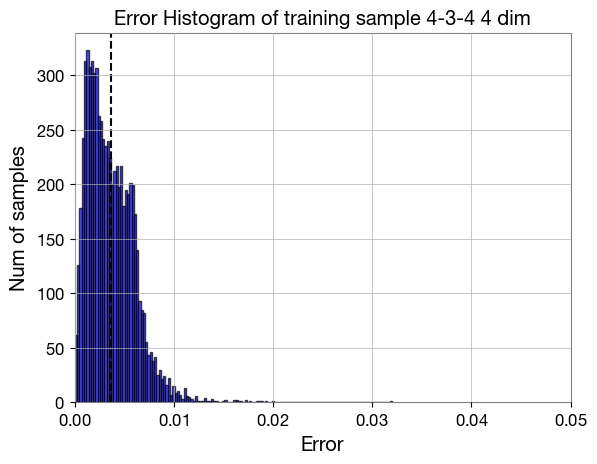

In [238]:
plt.hist(ReconstructedError_train, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of training sample 4-3-4 4 dim')
plt.xlim(0,0.05)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_train, color = 'black', linestyle = '--')
plt.show()

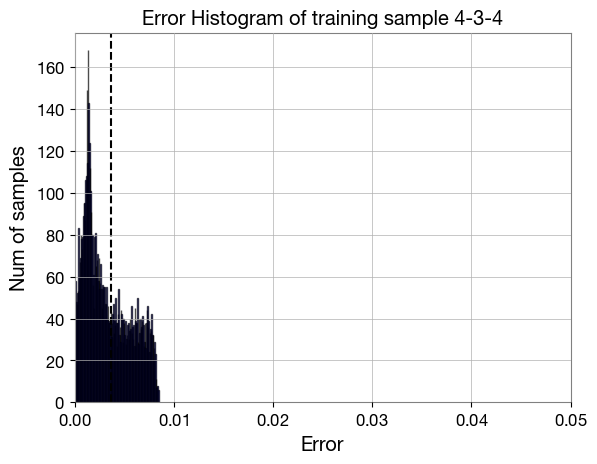

In [236]:
plt.hist(ReconstructedError_train, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of training sample 4-3-4 3 dim')
plt.xlim(0,0.05)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_train, color = 'black', linestyle = '--')
plt.show()

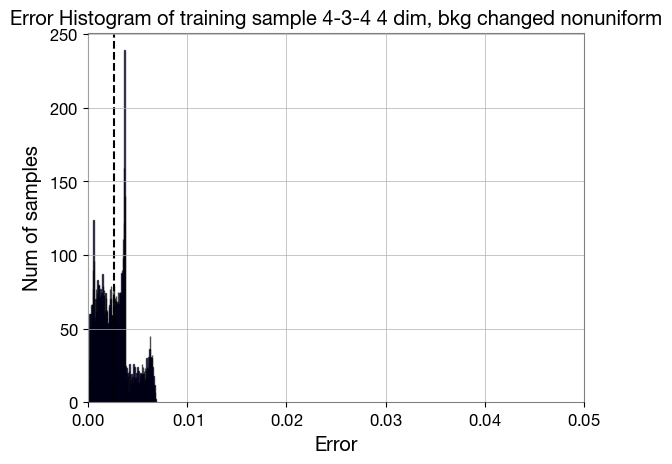

In [23]:
plt.hist(ReconstructedError_train, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of training sample 4-3-4 4 dim, bkg changed nonuniform')
plt.xlim(0,0.05)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_train, color = 'black', linestyle = '--')
plt.show()

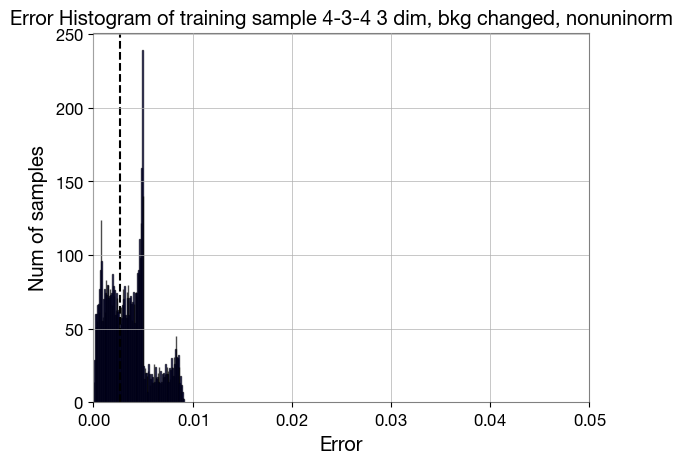

In [24]:
trainData = trainData[:, :3]
ReconstructedError_train = torch.mean((trainData - reconstructedData)**2,dim=1)
plt.hist(ReconstructedError_train, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of training sample 4-3-4 3 dim, bkg changed, nonuninorm')
plt.xlim(0,0.05)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_train, color = 'black', linestyle = '--')
plt.show()

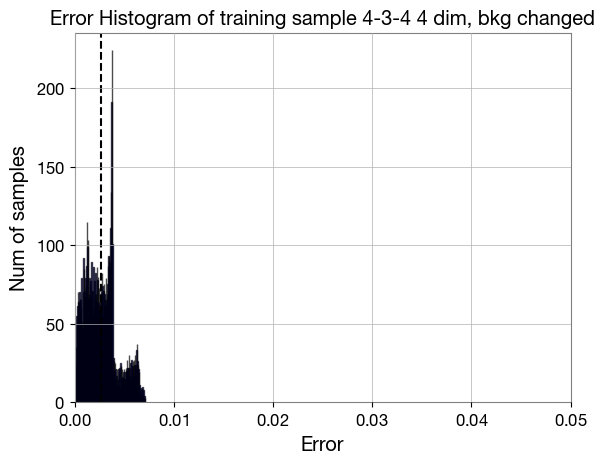

In [20]:
plt.hist(ReconstructedError_train, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of training sample 4-3-4 4 dim, bkg changed')
plt.xlim(0,0.05)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_train, color = 'black', linestyle = '--')
plt.show()

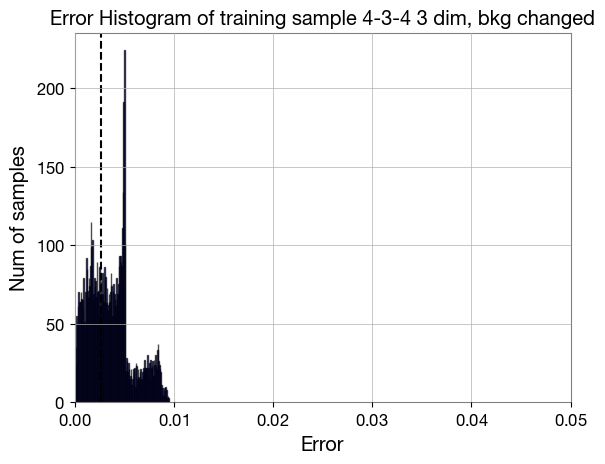

In [21]:
trainData = trainData[:, :3]
ReconstructedError_train = torch.mean((trainData - reconstructedData)**2,dim=1)
plt.hist(ReconstructedError_train, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of training sample 4-3-4 3 dim, bkg changed, uninorm')
plt.xlim(0,0.05)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_train, color = 'black', linestyle = '--')
plt.show()

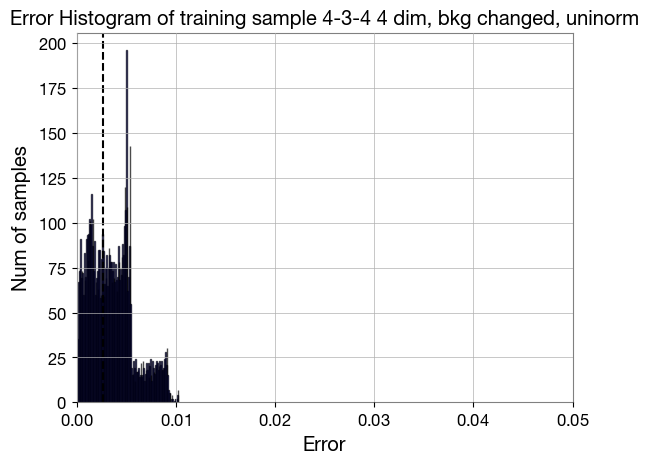

In [329]:
trainData = trainData[:, :3]
ReconstructedError_train = torch.mean((trainData - reconstructedData)**2,dim=1)
plt.hist(ReconstructedError_train, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of training sample 4-3-4 4 dim, bkg changed, uninorm')
plt.xlim(0,0.05)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_train, color = 'black', linestyle = '--')
plt.show()

In [220]:
_, decodedTestdata = autoencoder(testData)
decodedTestdata = decodedTestdata.double()
reconstructedData = decodedTestdata.detach().numpy()
ReconstructedError_test = torch.mean((testData - reconstructedData)**2,dim=1)
MSE_test = ReconstructedError_test.mean()

In [ ]:
testData

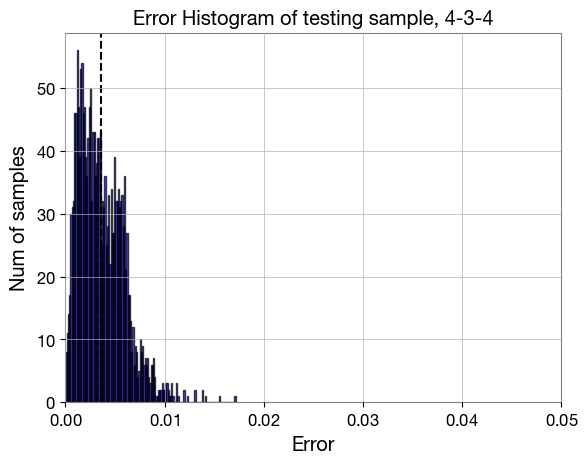

In [222]:
plt.hist(ReconstructedError_test, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of testing sample, 4-3-4')
plt.xlim(0,0.05)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_test, color = 'black', linestyle = '--')
plt.show()

In [25]:


# 指定立体角度区间
min_theta = 0  # 最小极角
max_theta = math.pi / 8  # 最大极角
min_phi = 0  # 最小方位角
max_phi = 2 * math.pi  # 最大方位角

# 生成随机的三维向量
num_vectors = 200  # 生成向量的数量
vectors = []
for _ in range(num_vectors):
    vector = generate_random_signal_vector(min_theta, max_theta, min_phi, max_phi)
    vectors.append(vector)
    
data_injected = np.array(vectors)

In [26]:
data_injected_normalized, junk1, junk2 = bunch_normalization(data_injected.copy())
data_injected_normalized = np.hstack((data_injected_normalized, np.array(junk2).reshape(200,1)))
data_injected_tensored = torch.FloatTensor(data_injected_normalized)
_, decodedTestdata = autoencoder(data_injected_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData = decodedTestdata.detach().numpy()
ReconstructedError_injected = torch.mean((data_injected_tensored - reconstructedData)**2,dim=1)
MSE_injected = ReconstructedError_injected.mean()

In [28]:
ReconstructedError_injected = np.mean((data_injected_tensored.numpy()[:, :3] - reconstructedData[:, :3])**2, axis = 1)

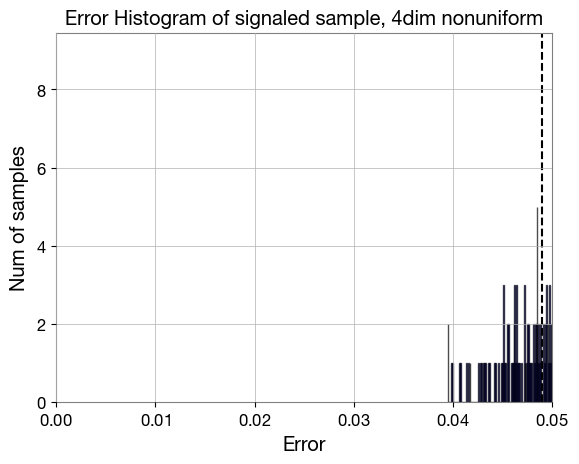

In [27]:
plt.hist(ReconstructedError_injected, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of signaled sample, 4dim nonuniform')
plt.xlim(0,0.05)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_injected, color = 'black', linestyle = '--')
plt.show()

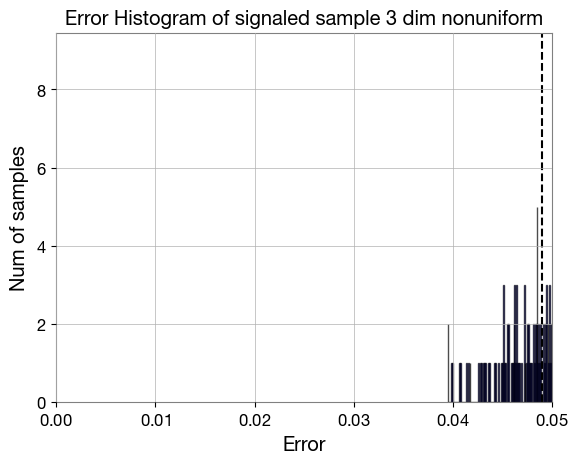

In [28]:
plt.hist(ReconstructedError_injected, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of signaled sample 3 dim nonuniform')
plt.xlim(0,0.05)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_injected, color = 'black', linestyle = '--')
plt.show()

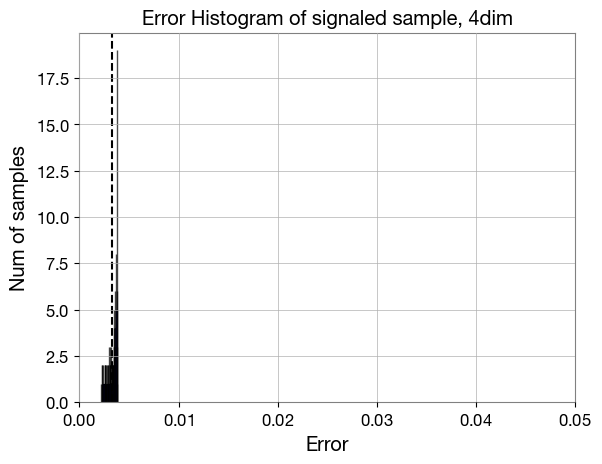

In [27]:
plt.hist(ReconstructedError_injected, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of signaled sample, 4dim')
plt.xlim(0,0.05)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_injected, color = 'black', linestyle = '--')
plt.show()

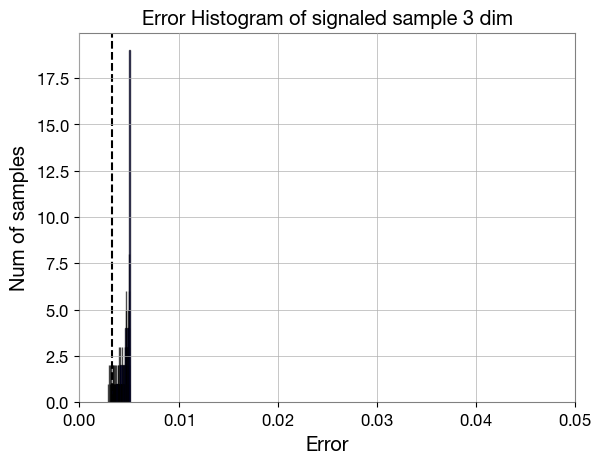

In [29]:
plt.hist(ReconstructedError_injected, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of signaled sample 3 dim')
plt.xlim(0,0.05)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MSE_injected, color = 'black', linestyle = '--')
plt.show()